In [1]:
import datetime
import os
import itertools
import pickle
import numpy as np
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 500)

#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

In [2]:
from multiprocessing import cpu_count

import xgboost as xgb
from xgboost import plot_importance

from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, f1_score, precision_score\
                            , recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

import shap

# 0.- Setting global parameters and importing data

In [3]:
seed = 42

In [4]:
train_data = pd.read_csv("data_artifacts/training_features_targets.csv")
display(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9979 entries, 0 to 9978
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   female                      9979 non-null   float64
 1   male                        9979 non-null   float64
 2   education_others            9979 non-null   float64
 3   graduate_school             9979 non-null   float64
 4   high_school                 9979 non-null   float64
 5   university                  9979 non-null   float64
 6   unknown                     9979 non-null   float64
 7   marriage_others             9979 non-null   float64
 8   married                     9979 non-null   float64
 9   single                      9979 non-null   float64
 10  limit_bal                   9979 non-null   float64
 11  age                         9979 non-null   int64  
 12  bal_amt1                    9979 non-null   float64
 13  bal_amt2                    9979 

None

,female,male,education_others,graduate_school,high_school,university,unknown,marriage_others,married,single,limit_bal,age,bal_amt1,bal_amt2,bal_amt3,bal_amt4,bal_amt5,bal_amt6,default.payment.next.month
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,50000.0,23,48463.0,47321.0,45791.0,39230.0,26797.0,27364.0,0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,10000.0,25,7025.0,141.0,1239.0,5911.0,-4510.0,10000.0,0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,150000.0,52,86248.0,88033.0,89852.0,90364.0,94431.0,97706.0,1
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,280000.0,26,24189.0,25252.0,26311.0,27638.0,28352.0,29217.0,0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,360000.0,41,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
x = train_data.drop( columns = train_data.columns[-1:])
y = train_data.drop( columns = train_data.columns[:-1])

# 1.0 Data Split
I split the dataset into train/test - 80/20. It would be useful to have a validation dataset, but the dataset small and with some categories with 1 element that I do not have a test validation. This would be useful to have in a production environment. The training is carried out using cross-validation which creates a val dataset for the purpose of training.

In [6]:
(X_train, X_test, Y_train, Y_test) = train_test_split(x, y\
                                                    , test_size = 0.2, random_state= 42\
                                                    , stratify  = y)

In [7]:
# Separate majority and minority classes
index_majority = Y_train[Y_train['default.payment.next.month'] == 0].index.values
index_minority = Y_train[Y_train['default.payment.next.month'] == 1].index.values

df_majority = X_train.loc[index_majority,:]
df_minority = X_train.loc[index_minority,:]

print('df_majority.shape', df_majority.shape, 'df_minority.shape', df_minority.shape)

# Upsample minority class
df_minority_upsampled = resample(df_minority 
                                 , replace      = True     # sample with replacement
                                 , n_samples    = df_majority.shape[0]    # to match majority class
                                 , random_state = 42) # reproducible results

print('df_majority.shape:', df_majority.shape, 'df_minority_upsampled.shape:', df_minority_upsampled.shape)

# Combine majority class with upsampled minority class
X_train_upsampled = pd.concat([df_majority, df_minority_upsampled])
Y_train_upsampled = Y_train.loc[X_train_upsampled.index,:]

X_train_upsampled = X_train_upsampled.reset_index(drop=True)
Y_train_upsampled = Y_train_upsampled.reset_index(drop=True)
 
# Display new class counts
print('X_train_upsampled.shape:', X_train_upsampled.shape)
print('Y_train_upsampled.shape:', Y_train_upsampled.shape)
#training_data_upsampled['default.payment.next.month'].value_counts()

df_majority.shape (6194, 18) df_minority.shape (1789, 18)
df_majority.shape: (6194, 18) df_minority_upsampled.shape: (6194, 18)
X_train_upsampled.shape: (12388, 18)
Y_train_upsampled.shape: (12388, 1)


In [8]:
X_train.to_csv('data_artifacts/X_train.csv', index = False)
X_train_upsampled.to_csv('data_artifacts/X_train_upsampled.csv', index = False)
X_test.to_csv('data_artifacts/X_test.csv', index = False)
Y_train.to_csv('data_artifacts/Y_train.csv', index = False)
Y_train_upsampled.to_csv('data_artifacts/Y_train_upsampled.csv', index = False)
Y_test.to_csv('data_artifacts/Y_test.csv', index = False)

# 2.0 Model Training

While I don't normalise the data for the XGBoost model, it could have been useful if I were comparing different models some of which might require data scaling (linear regression).
https://datascience.stackexchange.com/questions/60950/is-it-necessary-to-normalise-data-for-xgboost#:~:text=2%20Answers&text=Your%20rationale%20is%20indeed%20correct,normalization%20for%20the%20inputs%20either

https://github.com/dmlc/xgboost/issues/357

Also, XGBoost takes care of multicolinearity by default, which is another useful feature of the model.

## 2.1 XGBoost classifier model baseline

In [9]:
eval_metric = ['logloss', 'auc'] #'merror',

In [10]:
xgb_baseline         = xgb.XGBClassifier(random_state = seed, n_jobs=cpu_count()//2) #seed)
eval_set             = [(X_train_upsampled.values, Y_train_upsampled.values), (X_test.values, Y_test.values)]
trained_xgb_baseline = xgb_baseline.fit(X_train_upsampled.values, Y_train_upsampled.values\
                                        , eval_metric = eval_metric \
                                        , eval_set = eval_set, verbose=True)
trained_xgb_baseline = xgb_baseline.fit(X_train_upsampled, Y_train_upsampled, eval_metric = eval_metric)
feature_importances  = xgb_baseline.feature_importances_ 

[0]	validation_0-logloss:0.65740	validation_0-auc:0.70639	validation_1-logloss:0.66880	validation_1-auc:0.63398
[1]	validation_0-logloss:0.63055	validation_0-auc:0.74479	validation_1-logloss:0.65455	validation_1-auc:0.64713
[2]	validation_0-logloss:0.61308	validation_0-auc:0.76417	validation_1-logloss:0.64576	validation_1-auc:0.65265
[3]	validation_0-logloss:0.59781	validation_0-auc:0.77432	validation_1-logloss:0.63961	validation_1-auc:0.65726
[4]	validation_0-logloss:0.58645	validation_0-auc:0.78414	validation_1-logloss:0.63413	validation_1-auc:0.65726
[5]	validation_0-logloss:0.57943	validation_0-auc:0.78775	validation_1-logloss:0.63329	validation_1-auc:0.65851
[6]	validation_0-logloss:0.57166	validation_0-auc:0.79271	validation_1-logloss:0.62930	validation_1-auc:0.66372
[7]	validation_0-logloss:0.56463	validation_0-auc:0.80251	validation_1-logloss:0.62779	validation_1-auc:0.66448
[8]	validation_0-logloss:0.56099	validation_0-auc:0.80433	validation_1-logloss:0.62633	validation_1-auc:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[26]	validation_0-logloss:0.47928	validation_0-auc:0.88855	validation_1-logloss:0.61573	validation_1-auc:0.65276
[27]	validation_0-logloss:0.47325	validation_0-auc:0.89295	validation_1-logloss:0.61426	validation_1-auc:0.65319
[28]	validation_0-logloss:0.46308	validation_0-auc:0.90215	validation_1-logloss:0.61212	validation_1-auc:0.65246
[29]	validation_0-logloss:0.46155	validation_0-auc:0.90326	validation_1-logloss:0.61211	validation_1-auc:0.65212
[30]	validation_0-logloss:0.45510	validation_0-auc:0.90808	validation_1-logloss:0.61054	validation_1-auc:0.65226
[31]	validation_0-logloss:0.45443	validation_0-auc:0.90831	validation_1-logloss:0.61096	validation_1-auc:0.65201
[32]	validation_0-logloss:0.44840	validation_0-auc:0.91378	validation_1-logloss:0.60917	validation_1-auc:0.65079
[33]	validation_0-logloss:0.44408	validation_0-auc:0.91725	validation_1-logloss:0.60992	validation_1-auc:0.64879
[34]	validation_0-logloss:0.44049	validation_0-auc:0.91917	validation_1-logloss:0.61083	validati

[99]	validation_0-logloss:0.27868	validation_0-auc:0.98575	validation_1-logloss:0.60885	validation_1-auc:0.62835


In [11]:
file_name = "model_artifacts/xgb_baseline.pkl"

# save
pickle.dump(trained_xgb_baseline, open(file_name, "wb"))

# load
trained_xgb_baseline = pickle.load(open(file_name, "rb"))

### 2.1.1 Checking overfitting/underfitting & on number of trees using rmse and mae
This should check should truly be done using a test/val dataset, hence in this case is used for illustration purposes.

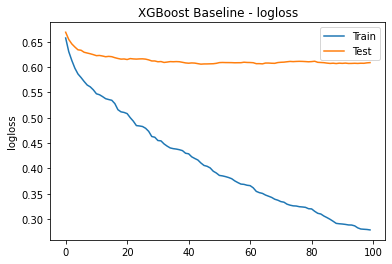

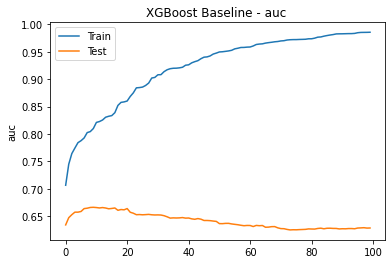

In [12]:
results = trained_xgb_baseline.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('logloss')
plt.title('XGBoost Baseline - logloss')
plt.show()
# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('auc')
plt.title('XGBoost Baseline - auc ')
plt.show()

### 2.1.2 Baseline metrics

In [13]:
def try_func(func, y_data, predictions):
    try:
        return func(y_data,predictions).round(2)
    except Exception as E:
        print(E)
        return np.nan

def calc_metrics(classifier, x_data, y_data):

    shape_x, shape_y = (x_data.shape, y_data.shape)
    print('Data shapes X:', shape_x, 'Y:', shape_y)
    predictions = classifier.predict(x_data) 

    
    acc  = try_func(accuracy_score, y_data, predictions)
    f1   = try_func(f1_score, y_data, predictions)
    prec = try_func(precision_score, y_data, predictions)
    rec  = try_func(recall_score, y_data, predictions)
    roc  = try_func(roc_auc_score, y_data, predictions)
    

    print('Metrics model -', 'accuracy:', acc, 'f1:', f1, 'precision:', prec, 'recall:', rec, 'roc_auc:', roc) 
    return [acc, f1, prec, rec, roc, shape_x, shape_y]

In [14]:
print("Metrics XGB classifier baseline on train data")
results_baseline_train = calc_metrics(trained_xgb_baseline, X_train_upsampled.values, Y_train_upsampled.values)

Metrics XGB classifier baseline on train data
Data shapes X: (12388, 18) Y: (12388, 1)
Metrics model - accuracy: 0.93 f1: 0.94 precision: 0.91 recall: 0.97 roc_auc: 0.93


In [15]:
print("Metrics XGB classifier baseline on test data")
results_baseline_test = calc_metrics(trained_xgb_baseline, X_test.values, Y_test.values)

Metrics XGB classifier baseline on test data
Data shapes X: (1996, 18) Y: (1996, 1)
Metrics model - accuracy: 0.68 f1: 0.34 precision: 0.31 recall: 0.37 roc_auc: 0.57


# 2.2 Fine tuning the XGB model (takes about 4 mins in 6 core laptop)

### I take inspiration from here https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [16]:
XGB_Options = { 
                'n_jobs':           1, #cpu_count()//2,
                'cv':               3,
                'scoring':          'roc_auc',#'roc_auc',
                'seed':             seed, 
    
                'max_depth':        np.arange(2,12,4),
                'min_child_weight': np.arange(1,10,3),
                'n_estimators':     [50, 100, 200], 

                'gamma':            np.arange(0.05,0.45,0.15),
                'colsample_bytree': np.arange(0.60, 0.95, 0.15),
                'subsample':        np.arange(0.60, 0.95, 0.15),
                'reg_alpha':        [1e-6, 1, 10], 
                'reg_lambda':       [1e-6, 1, 10],
                'learning_rate':    np.arange(0.025,0.150,0.050),
                 'verbose':         1            
              }

In [17]:
xgb_reg = xgb.XGBClassifier(random_state = XGB_Options['seed']\
                            , n_jobs = cpu_count()//2\
                            , eval_metric = eval_metric, use_label_encoder=False) 
start = datetime.datetime.now()
print('Starting with low learning rate and tuning: max_depth, min_child_weight, n_estimators')

params = {  
    "learning_rate":     [0.1],
    "max_depth":         XGB_Options['max_depth'], 
    "min_child_weight":  XGB_Options['min_child_weight'], 
    "n_estimators":      XGB_Options['n_estimators'], 

    "colsample_bytree":  [0.8], 
    "subsample":         [0.8],
    "gamma":             [0],
}

GSCV = GridSearchCV(xgb_reg, 
                    params,
                    cv                 = XGB_Options['cv'],
                    scoring            = XGB_Options['scoring'], 
                    n_jobs             = XGB_Options['n_jobs'], 
                    verbose            = XGB_Options['verbose'], 
                    return_train_score = True)

GSCV.fit(X_train_upsampled.values, Y_train_upsampled.values)
end = datetime.datetime.now()

print('Time to fit', (end-start))
print('best_params_:', GSCV.best_params_)#, 
print('best_score_:',  GSCV.best_score_)

print('Tuning: gamma')
start = datetime.datetime.now()
params = {  
    "learning_rate":    [0.1], 
    "max_depth":        [GSCV.best_params_['max_depth']],
    "min_child_weight": [GSCV.best_params_['min_child_weight']],
    "n_estimators":     [GSCV.best_params_['n_estimators']],

    "colsample_bytree": [0.8], 
    "subsample":        [0.8],
    "gamma":            XGB_Options['gamma'],

}

GSCV = GridSearchCV(xgb_reg, 
                    params,
                    cv                 = XGB_Options['cv'],
                    scoring            = XGB_Options['scoring'], 
                    n_jobs             = XGB_Options['n_jobs'],
                    verbose            = XGB_Options['verbose'], 
                    return_train_score = True)

GSCV.fit(X_train_upsampled.values, Y_train_upsampled.values)
end = datetime.datetime.now()

print('Time to fit xgb', (end-start))
print('best_params_:', GSCV.best_params_)#, 
print('best_score_:', GSCV.best_score_)


print('Tuning: colsample_bytree, subsample')
start = datetime.datetime.now()

params = {  
    "learning_rate":    [0.1], 
    "max_depth":        [GSCV.best_params_['max_depth']],
    "min_child_weight": [GSCV.best_params_['min_child_weight']],
    "n_estimators":     [GSCV.best_params_['n_estimators']],
    "gamma":            [GSCV.best_params_['gamma']],

    "colsample_bytree": XGB_Options['colsample_bytree'],
    "subsample":        XGB_Options['subsample'],

}

GSCV = GridSearchCV(xgb_reg, 
                    params,
                    cv                 = XGB_Options['cv'],
                    scoring            = XGB_Options['scoring'], 
                    n_jobs             = XGB_Options['n_jobs'],
                    verbose            = XGB_Options['verbose'], 
                    return_train_score = True)

GSCV.fit(X_train_upsampled.values, Y_train_upsampled.values)
end = datetime.datetime.now()

print('Time to fit', (end-start))
print('best_params_:', GSCV.best_params_) 
print('best_score_:', GSCV.best_score_)

print('Tuning: reg_alpha, reg_lambda')
start = datetime.datetime.now()
params = {  
    "learning_rate":    [0.1], 
    "max_depth":        [GSCV.best_params_['max_depth']],
    "min_child_weight": [GSCV.best_params_['min_child_weight']],
    "n_estimators":     [GSCV.best_params_['n_estimators']],
    "gamma":            [GSCV.best_params_['gamma']],

    "colsample_bytree": [GSCV.best_params_['colsample_bytree']], 
    "subsample":        [GSCV.best_params_['subsample']],


    "reg_alpha":        XGB_Options['reg_alpha'], 
    "reg_lambda":       XGB_Options['reg_lambda'], 
}

GSCV = GridSearchCV(xgb_reg, 
                    params,
                    cv                 = XGB_Options['cv'],
                    scoring            = XGB_Options['scoring'], 
                    n_jobs             = XGB_Options['n_jobs'],
                    verbose            = XGB_Options['verbose'], 
                    return_train_score = True)

GSCV.fit(X_train_upsampled.values, Y_train_upsampled.values)
end = datetime.datetime.now()

print('Time to fit', (end-start))
print('best_params_:', GSCV.best_params_)
print('best_score_:', GSCV.best_score_)


print('Tuning: learning_rate')
start = datetime.datetime.now()

params = {  
    "learning_rate":    XGB_Options['learning_rate'], 
    "max_depth":        [GSCV.best_params_['max_depth']],
    "min_child_weight": [GSCV.best_params_['min_child_weight']],
    "n_estimators":     [GSCV.best_params_['n_estimators']],
    "gamma":            [GSCV.best_params_['gamma']],

    "colsample_bytree": [GSCV.best_params_['colsample_bytree']], 
    "subsample":        [GSCV.best_params_['subsample']],


    "reg_alpha":        [GSCV.best_params_['reg_alpha']],
    "reg_lambda":       [GSCV.best_params_['reg_lambda']]
}

GSCV = GridSearchCV(xgb_reg, 
                    params,
                    cv                 = XGB_Options['cv'],
                    scoring            = XGB_Options['scoring'], 
                    n_jobs             = XGB_Options['n_jobs'],
                    verbose            = XGB_Options['verbose'], 
                    return_train_score = True)

GSCV.fit(X_train_upsampled.values, Y_train_upsampled.values) 
end = datetime.datetime.now()

print('Time to fit', (end-start))
print('best_params_:', GSCV.best_params_)
print('best_score_:', GSCV.best_score_)

Starting with low learning rate and tuning: max_depth, min_child_weight, n_estimators
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Time to fit 0:00:45.548715
best_params_: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
best_score_: 0.9447006286096409
Tuning: gamma
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Time to fit xgb 0:00:23.326889
best_params_: {'colsample_bytree': 0.8, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
best_score_: 0.9456926980288184
Tuning: colsample_bytree, subsample
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Time to fit 0:01:26.402811
best_params_: {'colsample_bytree': 0.9, 'gamma': 0.05, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.75}
best_score_: 0.9447157983099975
Tuning: reg_alpha, reg_lambda
Fitting

In [18]:
start = datetime.datetime.now()
xgb_tuned           = xgb.XGBClassifier(random_state=XGB_Options['seed']\
                                        , n_jobs=cpu_count()//2\
                                        , use_label_encoder=False) #seed)
xgb_tuned.set_params(**GSCV.best_params_)
trained_xgb_tuned   = xgb_tuned.fit(X_train_upsampled.values, Y_train_upsampled.values\
                                    , eval_metric = eval_metric \
                                    , eval_set = eval_set, verbose=False)
feature_importances = trained_xgb_tuned.feature_importances_ 
end = datetime.datetime.now()
print('Time to fit xgb', (end-start))

Time to fit xgb 0:00:05.315544


### 2.2.1 Tuned Model Metrics

In [19]:
file_name = "model_artifacts/xgb_tuned.pkl"

# save
pickle.dump(trained_xgb_tuned, open(file_name, "wb"))

# load
trained_xgb_tuned = pickle.load(open(file_name, "rb"))

In [20]:
print("Metrics XGB classifier tuned on train data")
metrics_tuned_model_train = calc_metrics(trained_xgb_tuned, X_train_upsampled.values, Y_train_upsampled.values)

Metrics XGB classifier tuned on train data
Data shapes X: (12388, 18) Y: (12388, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


In [21]:
print("Metrics XGB classifier tuned on test data")
metrics_tuned_model_test =  calc_metrics(trained_xgb_tuned, X_test.values, Y_test.values)

Metrics XGB classifier tuned on test data
Data shapes X: (1996, 18) Y: (1996, 1)
Metrics model - accuracy: 0.74 f1: 0.3 precision: 0.37 recall: 0.25 roc_auc: 0.56


### 2.2.2 Comparing Metrics with baseline

Considering the results in 2.1.2 the 'tuned' model performs better than the baseline model. Though this seems to come from a more complex model, as it's a lot deeper and with more boosting operations than the baseline. An issue that this could cause is overfitting, i.e. if this model was deployed to production it's performance might not be as good as in this offline setting.

In [22]:
metrics_names = ['accuracy_score', 'f1_score', 'precision_score', 'recall_score', 'roc_auc_score'\
                 , 'shape_x', 'shape_y']
columns = ['subset', 'sex', 'education', 'marriage' ] + metrics_names
metrics = pd.DataFrame([ ['Train'] + ['All'] + ['All'] + ['All'] + metrics_tuned_model_train\
                         , ['Test'] + ['All'] + ['All'] + ['All'] + metrics_tuned_model_test]\
                       , columns = columns)
metrics

,subset,sex,education,marriage,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,shape_x,shape_y
0,Train,All,All,All,1.00,1.0,1.00,1.00,1.00,"(12388, 18)","(12388, 1)"
1,Test,All,All,All,0.74,0.3,0.37,0.25,0.56,"(1996, 18)","(1996, 1)"


### 2.2.3 Model Metrics per category In/Out

In [23]:
combination_categories = pd.read_csv('data_artifacts/combination_categories.csv')
combination_categories

,SEX,EDUCATION,MARRIAGE,counts
0,female,university,married,1517
1,female,graduate_school,single,1403
2,female,university,single,1323
3,male,university,single,926
4,male,graduate_school,single,912
5,male,university,married,751
6,female,graduate_school,married,653
7,female,high_school,married,603
8,male,graduate_school,married,528
9,female,high_school,single,338


In [24]:
metric_datasets = [['Train', X_train_upsampled, Y_train_upsampled], ['Test', X_test, Y_test]]

for subset, dataset_x, dataset_y in metric_datasets:
    for i, row in combination_categories.iterrows():

        x_test_cat = dataset_x[ (dataset_x[row.SEX] == 1) \
                               & (dataset_x[row.EDUCATION] == 1)\
                               & (dataset_x[row.MARRIAGE] == 1)]
        y_test_cat = dataset_y.loc[x_test_cat.index, :]

        print('subset:', subset,'SEX:', row.SEX, 'EDUCATION:', row.EDUCATION, 'MARRIAGE:', row.MARRIAGE)
        """
        try: 
            results_cat = calc_metrics(trained_xgb_tuned, x_test_cat.values, y_test_cat.values)
        except Exception as E:
            print(E)
            pass
        """
        results_cat = calc_metrics(trained_xgb_tuned, x_test_cat.values, y_test_cat.values)        
        aux_df      = pd.DataFrame([ [subset] + [row.SEX] + [row.EDUCATION] + [row.MARRIAGE] +  results_cat]\
                               , columns = columns)    
    
        metrics     = metrics.append(aux_df)

        print('\n')

subset: Train SEX: female EDUCATION: university MARRIAGE: married
Data shapes X: (1923, 18) Y: (1923, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


subset: Train SEX: female EDUCATION: graduate_school MARRIAGE: single
Data shapes X: (1687, 18) Y: (1687, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


subset: Train SEX: female EDUCATION: university MARRIAGE: single
Data shapes X: (1651, 18) Y: (1651, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


subset: Train SEX: male EDUCATION: university MARRIAGE: single
Data shapes X: (1213, 18) Y: (1213, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


subset: Train SEX: male EDUCATION: graduate_school MARRIAGE: single
Data shapes X: (1056, 18) Y: (1056, 1)
Metrics model - accuracy: 0.99 f1: 0.99 precision: 0.99 recall: 1.0 roc_auc: 0.99


subset: Train SEX: male EDUCATION: university MARRIAGE: married
Data 

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


0.0 roc_auc: nan


subset: Train SEX: female EDUCATION: education_others MARRIAGE: single
Data shapes X: (15, 18) Y: (15, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


subset: Train SEX: female EDUCATION: education_others MARRIAGE: married
Data shapes X: (14, 18) Y: (14, 1)
Only one class present in y_true. ROC AUC score is not defined in that case.
Metrics model - accuracy: 1.0 f1: 0.0 precision: 0.0 recall: 0.0 roc_auc: nan


subset: Train SEX: male EDUCATION: high_school MARRIAGE: marriage_others
Data shapes X: (23, 18) Y: (23, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


subset: Train SEX: male EDUCATION: graduate_school MARRIAGE: marriage_others
Data shapes X: (7, 18) Y: (7, 1)
Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


subset: Train SEX: female EDUCATION: graduate_school MARRIAGE: marriage_others
Data shapes X: (10, 18) Y: (10, 1)
Metrics model - accuracy: 1.0 f1: 1.0 p

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use

Only one class present in y_true. ROC AUC score is not defined in that case.
Metrics model - accuracy: 1.0 f1: 0.0 precision: 0.0 recall: 0.0 roc_auc: nan


subset: Train SEX: female EDUCATION: education_others MARRIAGE: marriage_others
Data shapes X: (1, 18) Y: (1, 1)
Only one class present in y_true. ROC AUC score is not defined in that case.
Metrics model - accuracy: 1.0 f1: 0.0 precision: 0.0 recall: 0.0 roc_auc: nan


subset: Train SEX: female EDUCATION: unknown MARRIAGE: marriage_others
Data shapes X: (0, 18) Y: (0, 1)
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
Metrics model - accuracy: nan f1: nan precision: nan recall: nan roc_auc: nan


subset: Train SEX: male EDUCATION: education_others MARRIAGE: marriage_others
Data shapes X: (1, 18) Y: (1, 1)
Only one class present in y_true. ROC 

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.


subset: Test SEX: male EDUCATION: university MARRIAGE: single
Data shapes X: (200, 18) Y: (200, 1)
Metrics model - accuracy: 0.71 f1: 0.33 precision: 0.34 recall: 0.31 roc_auc: 0.57


subset: Test SEX: male EDUCATION: graduate_school MARRIAGE: single
Data shapes X: (197, 18) Y: (197, 1)
Metrics model - accuracy: 0.81 f1: 0.27 precision: 0.33 recall: 0.23 roc_auc: 0.57


subset: Test SEX: male EDUCATION: university MARRIAGE: married
Data shapes X: (136, 18) Y: (136, 1)
Metrics model - accuracy: 0.65 f1: 0.27 precision: 0.33 recall: 0.23 roc_auc: 0.52


subset: Test SEX: female EDUCATION: graduate_school MARRIAGE: married
Data shapes X: (141, 18) Y: (141, 1)
Metrics model - accuracy: 0.78 f1: 0.34 precision: 0.5 recall: 0.26 roc_auc: 0.59


subset: Test SEX: female EDUCATION: high_school MARRIAGE: married
Data shapes X: (113, 18) Y: (113, 1)
Metrics model - accuracy: 0.74 f1: 0.41 precision: 0.48 recall: 0.36 roc_auc: 0.61


subset: Test SEX: male EDUCATION: graduate_school MARRIAGE: mar

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_d

Metrics model - accuracy: 1.0 f1: 1.0 precision: 1.0 recall: 1.0 roc_auc: 1.0


subset: Test SEX: male EDUCATION: university MARRIAGE: marriage_others
Data shapes X: (5, 18) Y: (5, 1)
Metrics model - accuracy: 0.4 f1: 0.0 precision: 0.0 recall: 0.0 roc_auc: 0.33


subset: Test SEX: male EDUCATION: unknown MARRIAGE: single
Data shapes X: (4, 18) Y: (4, 1)
Only one class present in y_true. ROC AUC score is not defined in that case.
Metrics model - accuracy: 1.0 f1: 0.0 precision: 0.0 recall: 0.0 roc_auc: nan


subset: Test SEX: female EDUCATION: education_others MARRIAGE: single
Data shapes X: (4, 18) Y: (4, 1)
Only one class present in y_true. ROC AUC score is not defined in that case.
Metrics model - accuracy: 1.0 f1: 0.0 precision: 0.0 recall: 0.0 roc_auc: nan


subset: Test SEX: female EDUCATION: education_others MARRIAGE: married
Data shapes X: (1, 18) Y: (1, 1)
Only one class present in y_true. ROC AUC score is not defined in that case.
Metrics model - accuracy: 1.0 f1: 0.0 precisi

F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
Metrics model - accuracy: nan f1: nan precision: nan recall: nan roc_auc: nan


subset: Test SEX: male EDUCATION: education_others MARRIAGE: single
Data shapes X: (2, 18) Y: (2, 1)
Metrics model - accuracy: 0.0 f1: 0.0 precision: 0.0 recall: 0.0 roc_auc: 0.0


subset: Test SEX: female EDUCATION: education_others MARRIAGE: marriage_others
Data shapes X: (0, 18) Y: (0, 1)
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
Metrics model - accuracy: nan f1: nan precision: nan recall: nan roc_auc: nan


subset: Test SEX: female EDUCATION: unknown MARRIAGE: marriage_othe

In [25]:
metrics[ metrics.roc_auc_score.isnull()]

,subset,sex,education,marriage,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,shape_x,shape_y
0,Train,male,unknown,marriage_others,1.0,0.0,0.0,0.0,NaN,"(87, 18)","(87, 1)"
0,Train,male,unknown,single,1.0,0.0,0.0,0.0,NaN,"(18, 18)","(18, 1)"
0,Train,female,education_others,married,1.0,0.0,0.0,0.0,NaN,"(14, 18)","(14, 1)"
0,Train,male,education_others,married,1.0,0.0,0.0,0.0,NaN,"(6, 18)","(6, 1)"
0,Train,male,education_others,single,1.0,0.0,0.0,0.0,NaN,"(4, 18)","(4, 1)"
0,Train,female,education_others,marriage_others,1.0,0.0,0.0,0.0,NaN,"(1, 18)","(1, 1)"
0,Train,female,unknown,marriage_others,NaN,NaN,NaN,NaN,NaN,"(0, 18)","(0, 1)"
0,Train,male,education_others,marriage_others,1.0,0.0,0.0,0.0,NaN,"(1, 18)","(1, 1)"
0,Test,male,unknown,marriage_others,1.0,0.0,0.0,0.0,NaN,"(13, 18)","(13, 1)"
0,Test,female,university,marriage_others,0.4,0.0,0.0,0.0,NaN,"(5, 18)","(5, 1)"


In [26]:
metrics[(metrics.subset == 'Test') & (metrics.sex == 'female') & (metrics.education == 'education_others') ]

,subset,sex,education,marriage,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,shape_x,shape_y
0,Test,female,education_others,single,1.0,0.0,0.0,0.0,NaN,"(4, 18)","(4, 1)"
0,Test,female,education_others,married,1.0,0.0,0.0,0.0,NaN,"(1, 18)","(1, 1)"
0,Test,female,education_others,marriage_others,NaN,NaN,NaN,NaN,NaN,"(0, 18)","(0, 1)"


In [27]:
metrics[(metrics.sex == 'All') & (metrics.education == 'All') & (metrics.marriage == 'All') ]

,subset,sex,education,marriage,accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,shape_x,shape_y
0,Train,All,All,All,1.00,1.0,1.00,1.00,1.00,"(12388, 18)","(12388, 1)"
1,Test,All,All,All,0.74,0.3,0.37,0.25,0.56,"(1996, 18)","(1996, 1)"


### 2.2.4 Metrics by categories  - visualisation

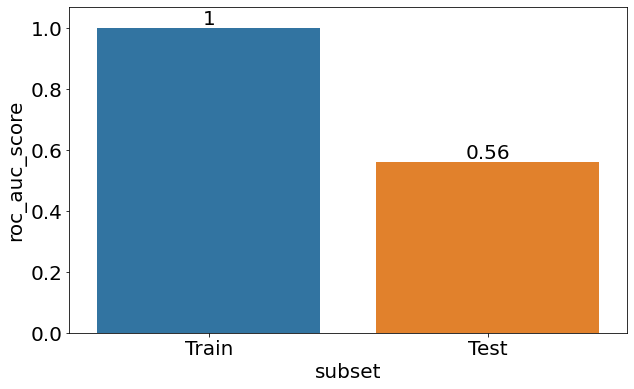

In [28]:
plot_df = metrics[ (metrics['sex'] =='All') & (metrics['education'] =='All') & (metrics['marriage'] =='All')]

plt.figure(figsize = (10, 6))
plot_metric = "roc_auc_score"
ax          = sns.barplot(x = "subset", y = plot_metric, data = plot_df)

for container in ax.containers:
    ax.bar_label(container, fontsize = 20)

ax.set_xlabel(ax.get_xlabel(), fontsize = 20);
ax.set_ylabel(ax.get_ylabel(), fontsize = 20);

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

    
ax.set_ylim(0, 1.07);

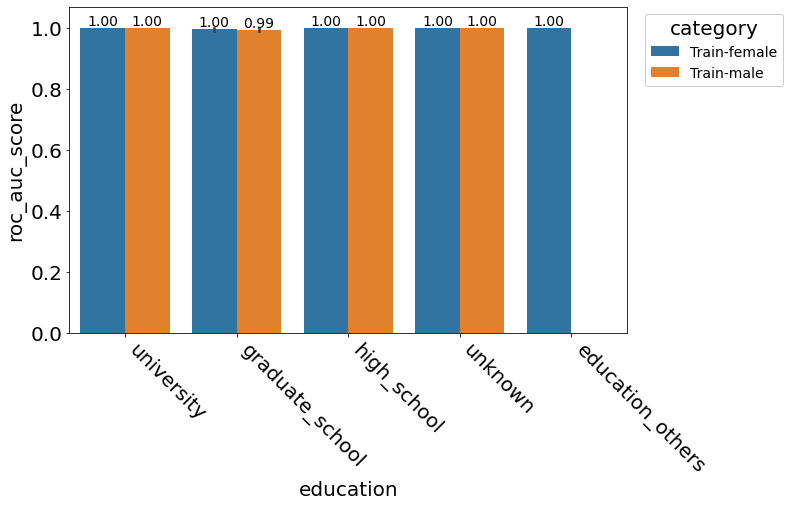

In [29]:
plot_df = metrics[ (metrics['sex'] !='All') & (metrics['subset'] == 'Train')].copy()
plot_df['category'] = plot_df['subset'] + '-' + plot_df['sex']

plt.figure(figsize = (10, 6))
plot_metric = "roc_auc_score"
ax = sns.barplot(x="education", y = plot_metric, hue = 'category', data= plot_df)
#ax = sns.barplot(x = "education", y = plot_metric, hue = 'sex', data= plot_df)

plt.xticks(rotation=-45, ha='left');    

for container in ax.containers:
    ax.bar_label(container, fontsize = 14, fmt='%.2f')
    
ax.set_xlabel(ax.get_xlabel(), fontsize = 20);
ax.set_ylabel(ax.get_ylabel(), fontsize = 20);

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(20)

#plt.legend(fontsize = 20)
#plt.setp( plt.gca().get_legend().get_title(),fontsize= 20);
ax.set_ylim(0, 1.07)
ax.legend(bbox_to_anchor=(1.02, 1.0), framealpha = 1, fontsize = 14, 
          title_fontsize = 20,title=ax.legend_.get_title().get_text());

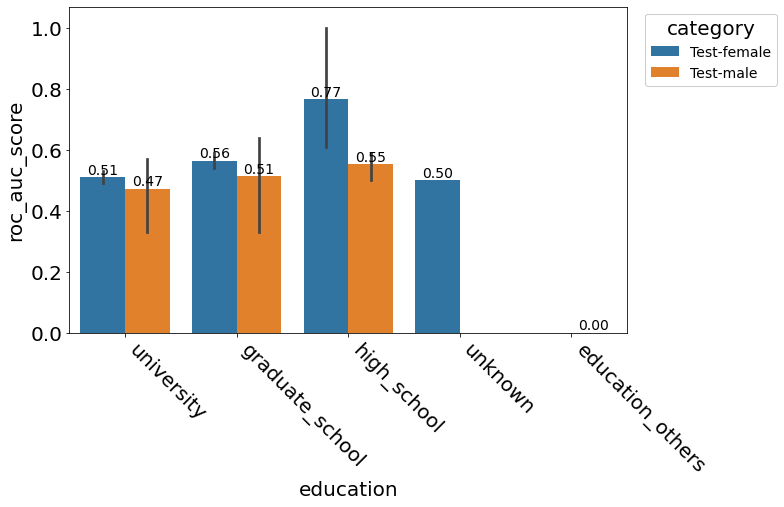

In [30]:
plot_df = metrics[ (metrics['sex'] !='All') & (metrics['subset'] == 'Test')].copy()
plot_df['category'] = plot_df['subset'] + '-' + plot_df['sex']

plt.figure(figsize = (10, 6))
plot_metric = "roc_auc_score"
ax = sns.barplot(x="education", y = plot_metric, hue = 'category', data= plot_df)
#ax = sns.barplot(x = "education", y = plot_metric, hue = 'sex', data= plot_df)

plt.xticks(rotation=-45, ha='left');    

for container in ax.containers:
    ax.bar_label(container, fontsize = 14, fmt='%.2f')
    
ax.set_xlabel(ax.get_xlabel(), fontsize = 20);
ax.set_ylabel(ax.get_ylabel(), fontsize = 20);

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(20)

#plt.legend(fontsize = 20)
#plt.setp( plt.gca().get_legend().get_title(),fontsize= 20);
ax.set_ylim(0, 1.07)
ax.legend(bbox_to_anchor=(1.02, 1.0), framealpha = 1, fontsize = 14, 
          title_fontsize = 20,title=ax.legend_.get_title().get_text());

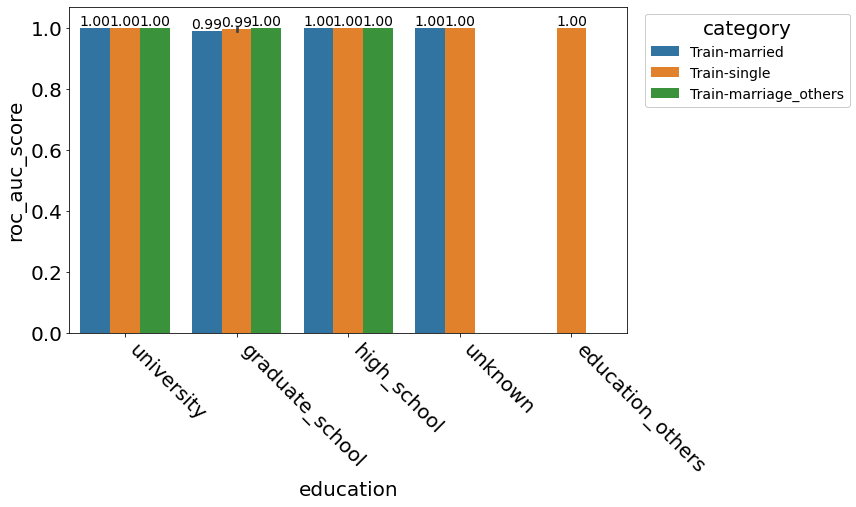

In [31]:
plot_df = metrics[ (metrics['marriage'] !='All') & (metrics['subset'] == 'Train')].copy()
plot_df['category'] = plot_df['subset'] + '-' + plot_df['marriage']

plt.figure(figsize = (10, 6))
plot_metric = "roc_auc_score"
ax = sns.barplot(x="education", y = plot_metric, hue = 'category', data= plot_df)
#ax = sns.barplot(x = "education", y = plot_metric, hue = 'sex', data= plot_df)

plt.xticks(rotation=-45, ha='left');    

for container in ax.containers:
    ax.bar_label(container, fontsize = 14, fmt='%.2f')
    
ax.set_xlabel(ax.get_xlabel(), fontsize = 20);
ax.set_ylabel(ax.get_ylabel(), fontsize = 20);

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(20)

#plt.legend(fontsize = 20)
#plt.setp( plt.gca().get_legend().get_title(),fontsize= 20);
ax.set_ylim(0, 1.07)
ax.legend(bbox_to_anchor=(1.02, 1.0), framealpha = 1, fontsize = 14, 
          title_fontsize = 20,title=ax.legend_.get_title().get_text());

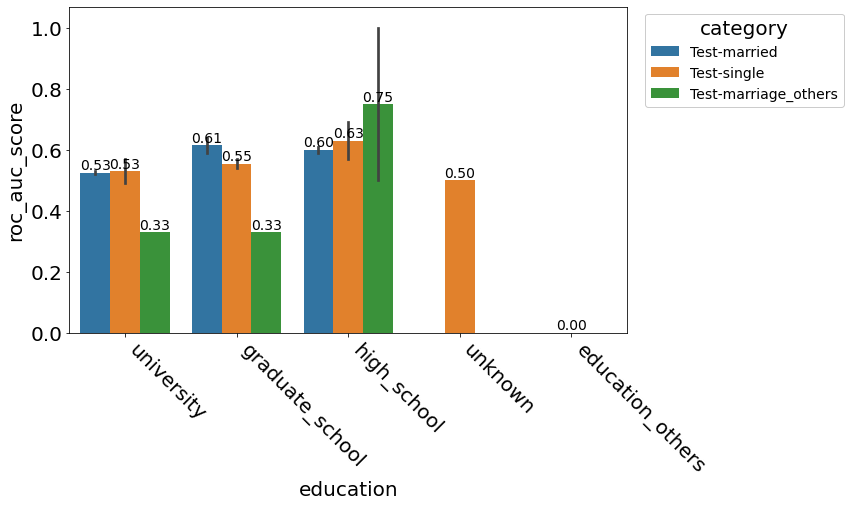

In [32]:
plot_df = metrics[ (metrics['marriage'] !='All') & (metrics['subset'] == 'Test')].copy()
plot_df['category'] = plot_df['subset'] + '-' + plot_df['marriage']

plt.figure(figsize = (10, 6))
plot_metric = "roc_auc_score"
ax = sns.barplot(x="education", y = plot_metric, hue = 'category', data= plot_df)
#ax = sns.barplot(x = "education", y = plot_metric, hue = 'sex', data= plot_df)

plt.xticks(rotation=-45, ha='left');    

for container in ax.containers:
    ax.bar_label(container, fontsize = 14, fmt='%.2f')
    
ax.set_xlabel(ax.get_xlabel(), fontsize = 20);
ax.set_ylabel(ax.get_ylabel(), fontsize = 20);

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    #label.set_fontname('Arial')
    label.set_fontsize(20)

#plt.legend(fontsize = 20)
#plt.setp( plt.gca().get_legend().get_title(),fontsize= 20);
ax.set_ylim(0, 1.07)
ax.legend(bbox_to_anchor=(1.02, 1.0), framealpha = 1, fontsize = 14, 
          title_fontsize = 20,title=ax.legend_.get_title().get_text());

# 3.0  Feature importance

## 3.1 Weight, Gain, Cover

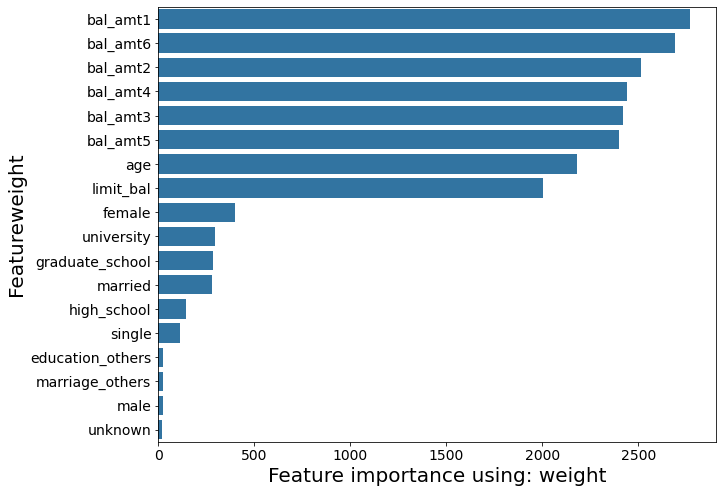

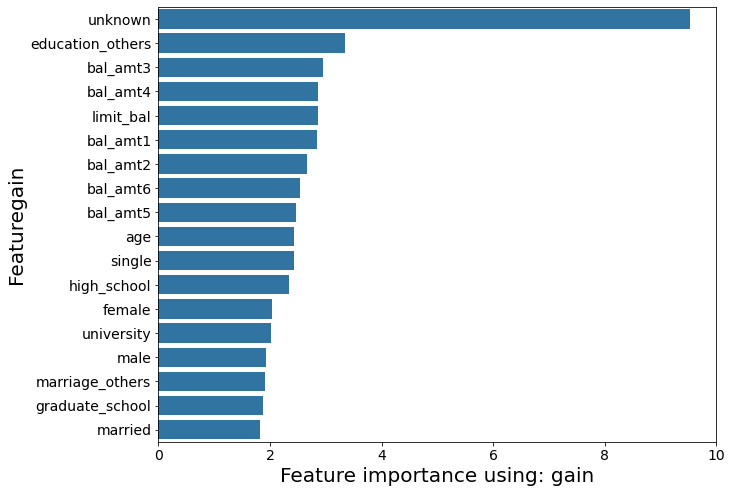

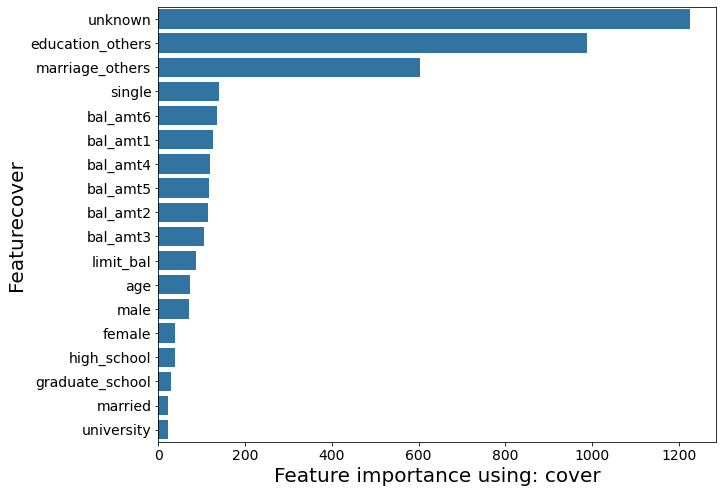

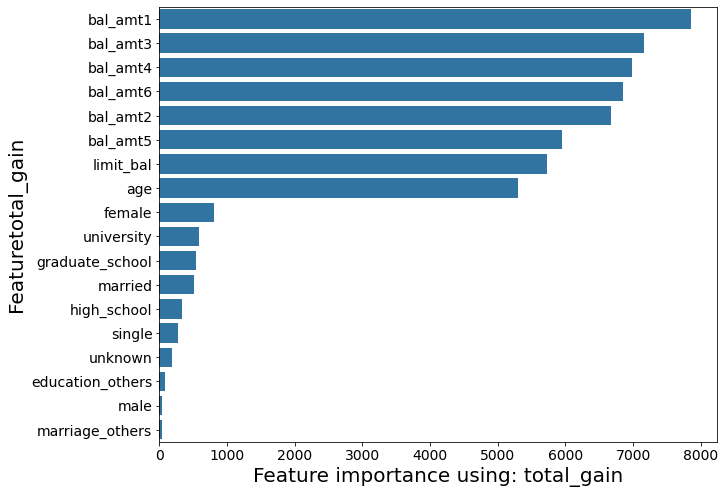

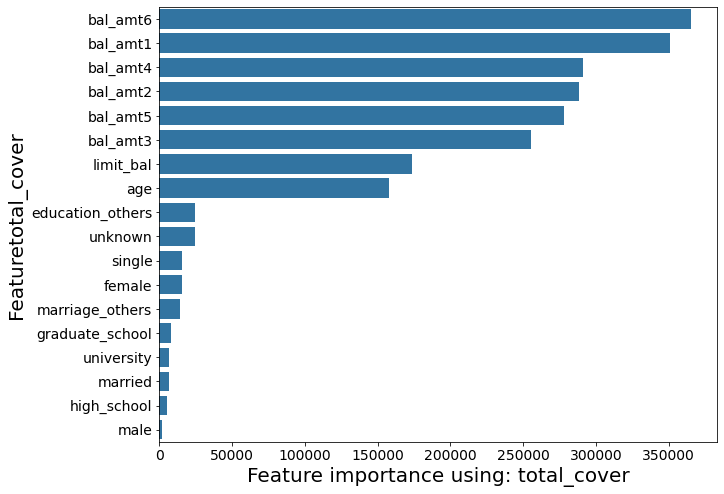

In [33]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

pal = sns.color_palette('tab10')

feature_names = X_train_upsampled.columns

for importance in ['weight', 'gain', 'cover', 'total_gain', 'total_cover']:
    dict_imp = trained_xgb_tuned.get_booster().get_score(importance_type= importance)
    
    imp_df = pd.DataFrame.from_dict(dict_imp, orient='index', columns = ['values'])
    imp_df = imp_df.reset_index().sort_values(by='values', ascending = False)
    
    plt.figure(figsize = (10,8))
    ax = sns.barplot(x="values", y="index", data=imp_df, color = pal.as_hex()[0])
    plt.xticks(fontsize=14, rotation=0)
    
    y_ticks = []
    for item in ax.get_yticklabels():
        index_feature = int(item.get_text().replace('f', ''))
        y_ticks.append(feature_names[index_feature])
       
    ax.set_yticklabels(y_ticks)
    plt.yticks(fontsize=14, rotation=0)
    ax.set_xlabel("Feature importance using: " + importance, fontsize =20)
    ax.set_ylabel("Feature" + importance, fontsize =20);

## 3.1 Shap values on the train dataset

In [34]:
explainer = shap.Explainer(trained_xgb_tuned)

In [35]:
shap_values = explainer(X_train_upsampled)
#shap_values = explainer(X_train, X100)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [36]:
with open("model_artifacts/shap_values_train.pkl","wb") as f:
    pickle.dump(shap_values, f)

In [37]:
with open("model_artifacts/shap_values_train.pkl","rb") as f:
    shap_values = pickle.load(f)

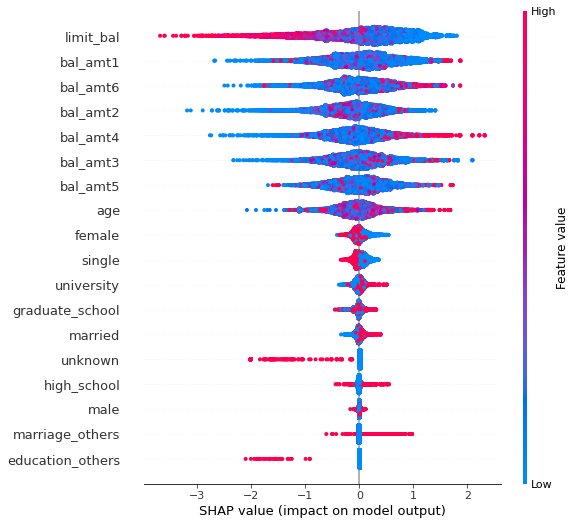

In [38]:
shap.initjs()
shap.summary_plot(shap_values, X_train_upsampled.values)

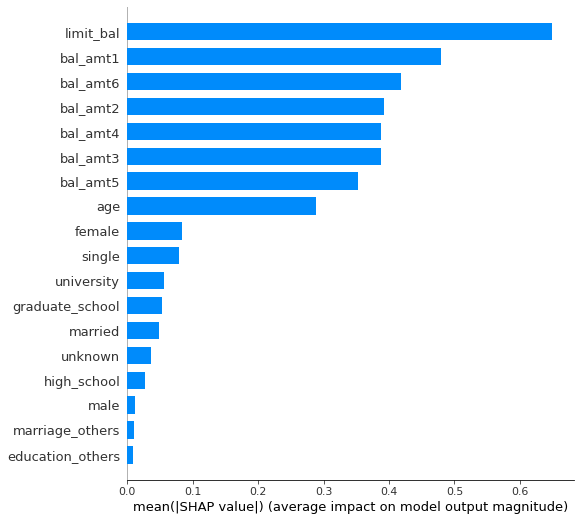

In [39]:
shap.summary_plot(shap_values, X_train_upsampled, plot_type="bar")

### The impact of each feature in a prediction

In [40]:
shap.initjs()
shap.plots.force(shap_values[0])

## 3.2 Shap values on the test dataset

In [41]:
explainer = shap.Explainer(trained_xgb_tuned)

In [42]:
shap_values = explainer(X_test)
#shap_values = explainer(X_train_upsampled, X100)

In [43]:
with open("model_artifacts/shap_values_test.pkl","wb") as f:
    pickle.dump(shap_values, f)

In [44]:
with open("model_artifacts/shap_values_test.pkl","rb") as f:
    shap_values = pickle.load(f)

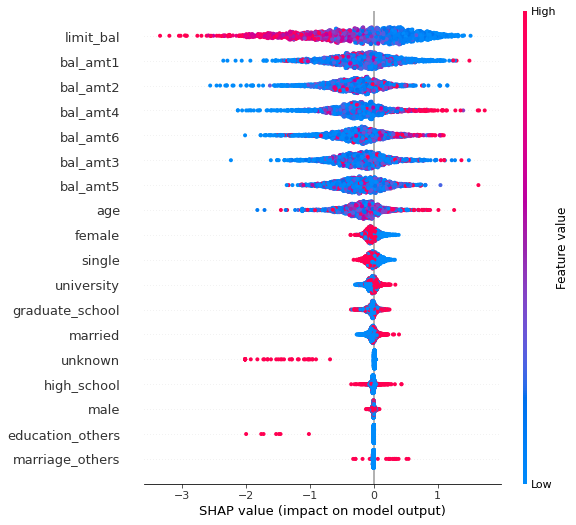

In [45]:
shap.initjs()
shap.summary_plot(shap_values, X_test.values)

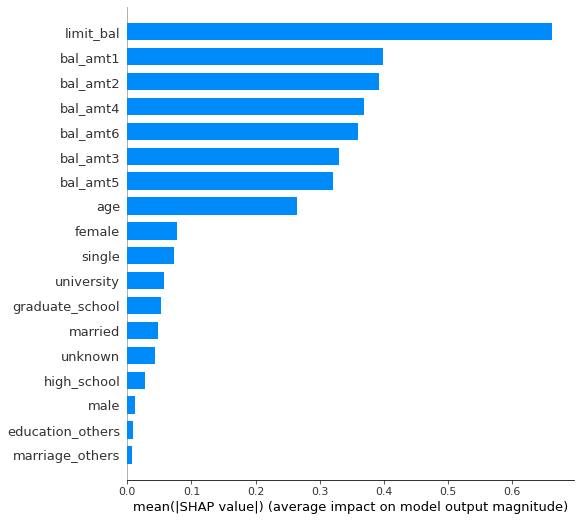

In [46]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

### The impact of each feature in a prediction

In [47]:
shap.initjs()
shap.plots.force(shap_values[0])

# 3.0 Avenues of improvement

Dataset and feature improvements:
- The categories with small number of records, for example education_others, should be discarded as they hamper the training, metrics and they have low predictive value according to shap and importances.
- Limit outliers in numerical features, for example using inter-quantile ranges.
- Do a more advanced feature selectior, for example using Chi-Squared, Mutual or others.


Additionally, acquiring a larger dataset that could unlock the following advantages:
- Make the categories with fewer items be more significant
- Consider including the PAY categories if there's more data to fill the many more categories to be created.
- Have a validation dataset would help studying overfitting.

In terms of model training and evaluation:
- Better hyperparameter optimisation method for example a bayesian based one.
- Study the decision tree (the necessary libraries, Graphviz make the environment a bit more difficult to transfer the environment)
- Evaluate other models, perhaps a Neural Network. Though it's my educated belief that the effort might not pay off.
- In-depth discussion between data science, domain experts and management about the of trade-offs between different model metrics.